In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# -------------------------------
# 1. Data Loading & Preparation
# -------------------------------
# Load the data (adjust the path as needed)
data_path = '../../data/clean/technology/clean_technology_close.csv'
df = pd.read_csv(data_path)

# Convert Date to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# -------------------------------
# 2. Calculate Performance Metrics
# -------------------------------
# Normalize prices for easier comparison (base=100)
normalized_df = df.div(df.iloc[0]) * 100

# Calculate total returns (percentage change from first to last day)
start_prices = df.iloc[0]
end_prices = df.iloc[-1]
returns = ((end_prices - start_prices) / start_prices) * 100

# Calculate daily returns, annualized volatility, and Sharpe ratios
daily_returns = df.pct_change().dropna()
volatility = daily_returns.std() * np.sqrt(252)

# Assume an annual risk-free rate of 2%
risk_free_rate = 0.02
daily_rf_rate = risk_free_rate / 252
excess_returns = daily_returns - daily_rf_rate
sharpe_ratios = (excess_returns.mean() * 252) / (daily_returns.std() * np.sqrt(252))

# -------------------------------
# 3. Identify Winners, Losers & Benchmarks (by Return)
# -------------------------------
top_n = 5  # number of winners/losers to select
# Winners: stocks with highest total returns
winners_return = returns.nlargest(top_n)
# Losers: stocks with lowest total returns
losers_return = returns.nsmallest(top_n)
# Benchmarks: stocks with total returns closest to the overall average
avg_return = returns.mean()
metric_diff = abs(returns - avg_return)
benchmark_tickers = metric_diff.nsmallest(3).index.tolist()

print("Winners by Return:")
print(winners_return, "\n")
print("Losers by Return:")
print(losers_return, "\n")
print("Benchmark Tickers:")
print(benchmark_tickers, "\n")



Winners by Return:
AMD     731.648870
ACLS    445.837462
LRCX    444.469220
JBL     432.718752
MPWR    415.044336
dtype: float64 

Losers by Return:
CAMP   -98.896278
MIND   -98.500000
LPSN   -96.508220
CMTL   -78.977845
CPSI   -68.127390
dtype: float64 

Benchmark Tickers:
['AZPN', 'KFRC', 'DOV'] 



In [39]:
# (Assuming you already identified winners_return, losers_return, benchmark_tickers from the full dataset)
# winners_return, losers_return, and benchmark_tickers each store tickers (indexes) for those groups.

# -------------------------------
# 2. Filter Data to Selected Tickers
# -------------------------------
# Combine unique tickers from Winners, Losers, and Benchmarks
selected_tickers = list(set(winners_return.index.tolist() + 
                            losers_return.index.tolist() + 
                            benchmark_tickers))

# Subset the main DataFrame to only these tickers
df_subset = df[selected_tickers].copy()

# Recompute everything for the subset
# Normalize prices (base=100)
normalized_subset = df_subset.div(df_subset.iloc[0]) * 100

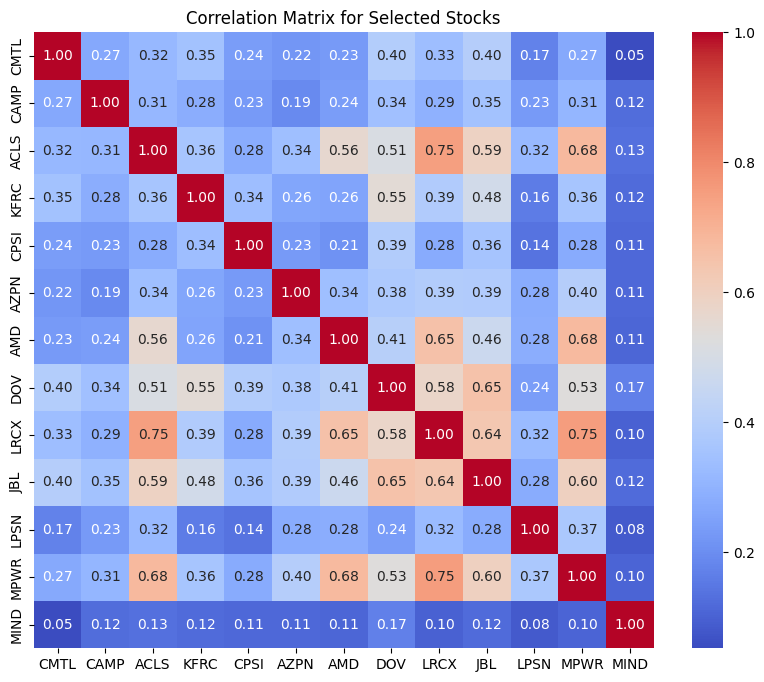

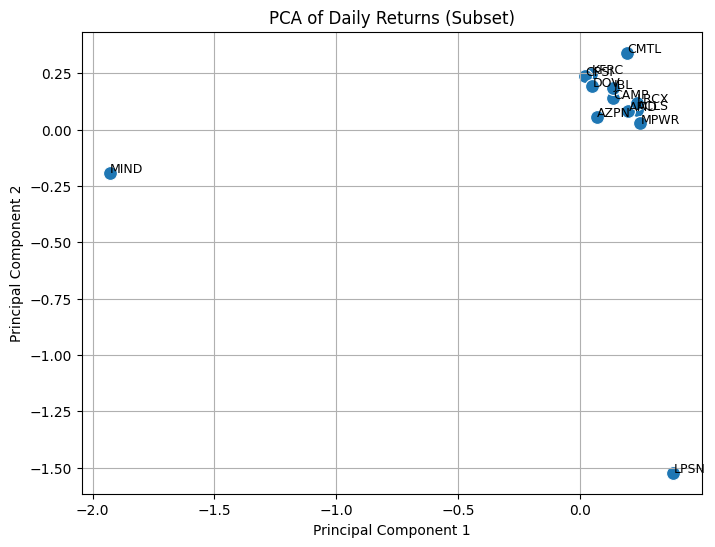

In [40]:

# --------------------------------------------------------
# 1. Correlation & Co-movement Analysis
# --------------------------------------------------------

# (a) Correlation Matrix Heatmap using daily returns
daily_returns_subset = df_subset.pct_change().dropna()
corr_matrix_subset = daily_returns_subset.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_subset, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix for Selected Stocks")
plt.savefig("correlation_heatmap_subset.png", dpi=300, bbox_inches='tight')
plt.show()

# (b) Principal Component Analysis (PCA) on daily returns
pca = PCA(n_components=2)
# Transpose so that stocks are features
pca_result = pca.fit_transform(daily_returns_subset.T)
pca_df = pd.DataFrame(pca_result, index=daily_returns_subset.columns, columns=["PC1", "PC2"])

plt.figure(figsize=(8, 6))
sns.scatterplot(x="PC1", y="PC2", data=pca_df, s=100)
for ticker in pca_df.index:
    plt.text(pca_df.loc[ticker, "PC1"]+0.001, pca_df.loc[ticker, "PC2"]+0.001, ticker, fontsize=9)
plt.title("PCA of Daily Returns (Subset)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.savefig("pca_daily_returns_subset.png", dpi=300, bbox_inches='tight')
plt.show()

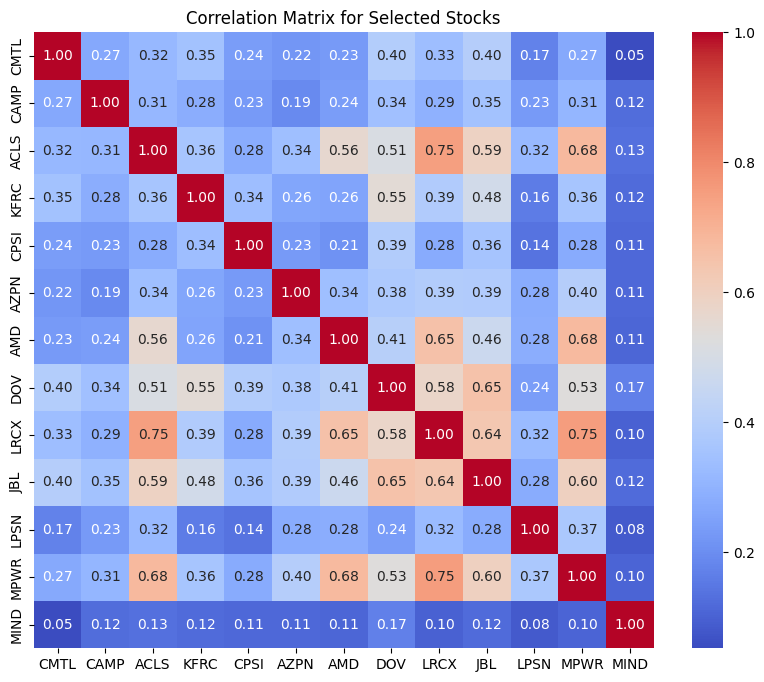

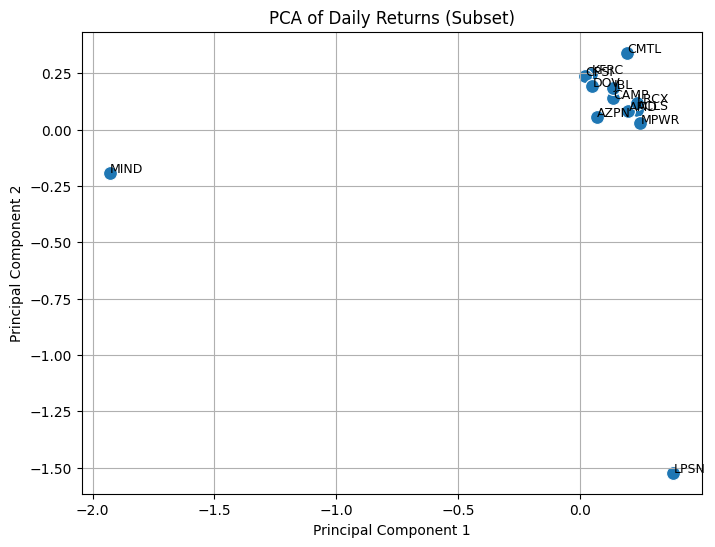

In [41]:

# --------------------------------------------------------
# 1. Correlation & Co-movement Analysis
# --------------------------------------------------------

# (a) Correlation Matrix Heatmap using daily returns
daily_returns_subset = df_subset.pct_change().dropna()
corr_matrix_subset = daily_returns_subset.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_subset, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix for Selected Stocks")
plt.savefig("correlation_heatmap_subset.png", dpi=300, bbox_inches='tight')
plt.show()

# (b) Principal Component Analysis (PCA) on daily returns
pca = PCA(n_components=2)
# Transpose so that stocks are features
pca_result = pca.fit_transform(daily_returns_subset.T)
pca_df = pd.DataFrame(pca_result, index=daily_returns_subset.columns, columns=["PC1", "PC2"])

plt.figure(figsize=(8, 6))
sns.scatterplot(x="PC1", y="PC2", data=pca_df, s=100)
for ticker in pca_df.index:
    plt.text(pca_df.loc[ticker, "PC1"]+0.001, pca_df.loc[ticker, "PC2"]+0.001, ticker, fontsize=9)
plt.title("PCA of Daily Returns (Subset)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.savefig("pca_daily_returns_subset.png", dpi=300, bbox_inches='tight')
plt.show()

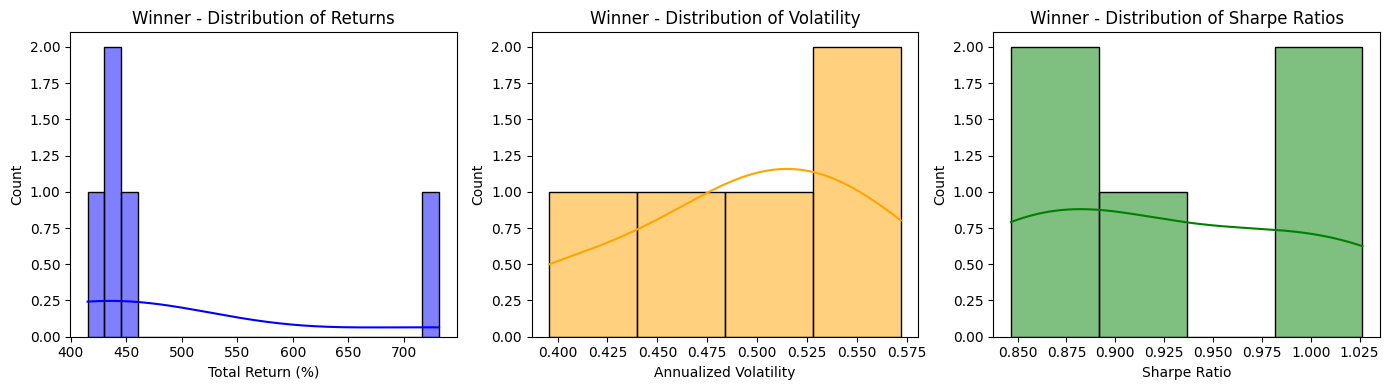

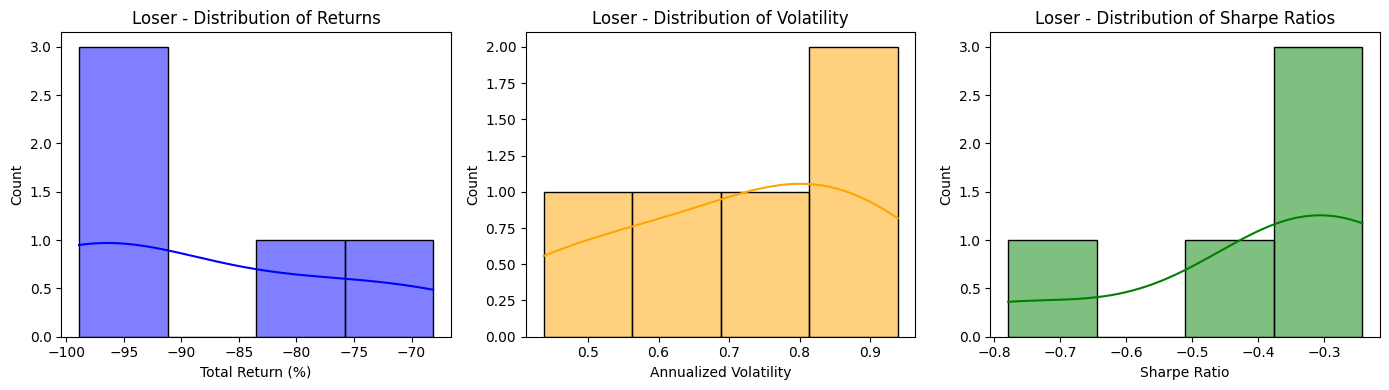

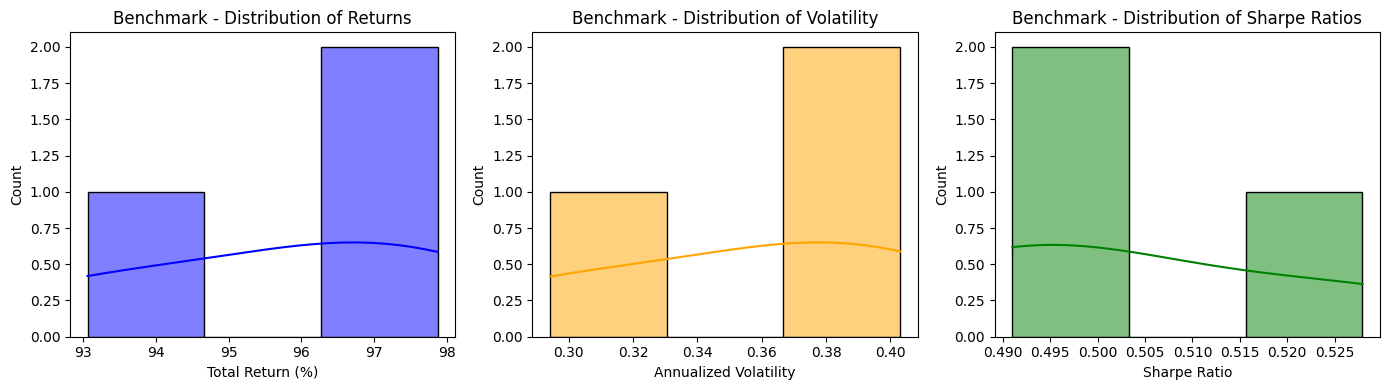

In [42]:
# Example: Creating group_df from your computed metrics and group labels

# Create a dictionary that assigns each ticker a group label
group_labels = {}
for ticker in returns.index:
    if ticker in winners_return.index:
        group_labels[ticker] = "Winner"
    elif ticker in losers_return.index:
        group_labels[ticker] = "Loser"
    elif ticker in benchmark_tickers:
        group_labels[ticker] = "Benchmark"
    else:
        group_labels[ticker] = "Other"  # if applicable

# Build group_df DataFrame using the computed metrics
group_df = pd.DataFrame({
    "Return": returns,
    "Volatility": volatility,
    "Sharpe": sharpe_ratios,
    "Group": [group_labels[ticker] for ticker in returns.index]
})

# Now, you can run your plotting code:
import matplotlib.pyplot as plt
import seaborn as sns

groups_to_plot = ["Winner", "Loser", "Benchmark"]

for group in groups_to_plot:
    # Filter rows for the current group
    subset = group_df[group_df["Group"] == group]
    
    # Skip if subset is empty (no tickers in this group)
    if subset.empty:
        continue
    
    # Create a figure with three subplots
    plt.figure(figsize=(14, 4))
    
    # 1. Distribution of Returns
    plt.subplot(1, 3, 1)
    sns.histplot(subset["Return"], kde=True, color='blue')
    plt.title(f"{group} - Distribution of Returns")
    plt.xlabel("Total Return (%)")
    
    # 2. Distribution of Volatility
    plt.subplot(1, 3, 2)
    sns.histplot(subset["Volatility"], kde=True, color='orange')
    plt.title(f"{group} - Distribution of Volatility")
    plt.xlabel("Annualized Volatility")
    
    # 3. Distribution of Sharpe Ratios
    plt.subplot(1, 3, 3)
    sns.histplot(subset["Sharpe"], kde=True, color='green')
    plt.title(f"{group} - Distribution of Sharpe Ratios")
    plt.xlabel("Sharpe Ratio")
    
    plt.tight_layout()
    plt.savefig(f'distribution_plots_{group}.png', dpi=300, bbox_inches='tight')
    plt.show()


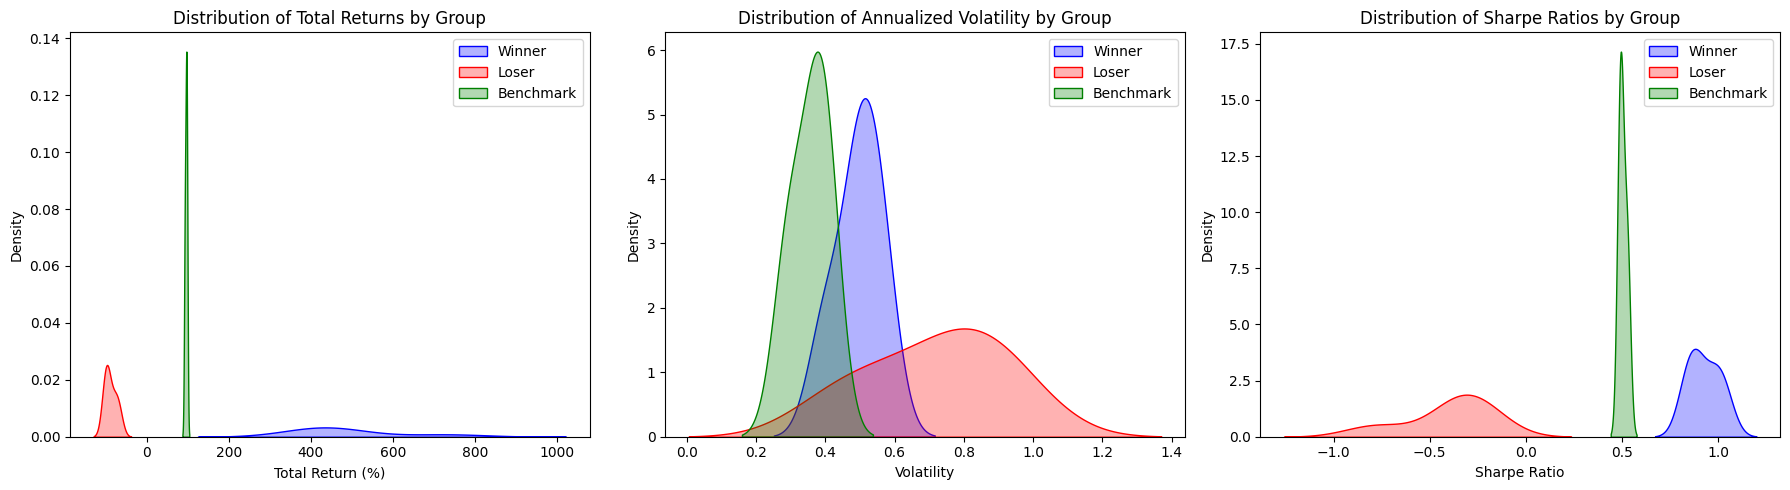

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the groups and colors for clarity
groups_to_plot = ["Winner", "Loser", "Benchmark"]
colors = {"Winner": "blue", "Loser": "red", "Benchmark": "green"}

plt.figure(figsize=(18, 5))

# Distribution of Total Returns
plt.subplot(1, 3, 1)
for group in groups_to_plot:
    subset = group_df[group_df["Group"] == group]
    # Use a kernel density plot to overlay the distributions
    sns.kdeplot(subset["Return"], label=group, color=colors[group], fill=True, alpha=0.3)
plt.title("Distribution of Total Returns by Group")
plt.xlabel("Total Return (%)")
plt.legend()

# Distribution of Annualized Volatility
plt.subplot(1, 3, 2)
for group in groups_to_plot:
    subset = group_df[group_df["Group"] == group]
    sns.kdeplot(subset["Volatility"], label=group, color=colors[group], fill=True, alpha=0.3)
plt.title("Distribution of Annualized Volatility by Group")
plt.xlabel("Volatility")
plt.legend()

# Distribution of Sharpe Ratios
plt.subplot(1, 3, 3)
for group in groups_to_plot:
    subset = group_df[group_df["Group"] == group]
    sns.kdeplot(subset["Sharpe"], label=group, color=colors[group], fill=True, alpha=0.3)
plt.title("Distribution of Sharpe Ratios by Group")
plt.xlabel("Sharpe Ratio")
plt.legend()

plt.tight_layout()
plt.savefig("combined_distribution_plots.png", dpi=300, bbox_inches="tight")
plt.show()


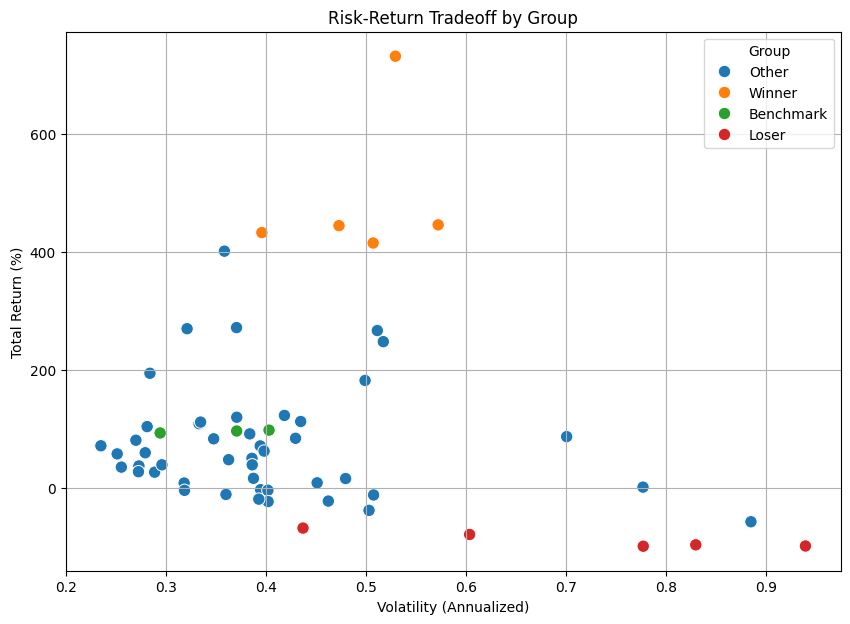

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import statsmodels.api as sm
import scipy.stats as stats

########################################
# 6. Risk-Return Relationship
########################################
# Single scatter plot for all groups
plt.figure(figsize=(10, 7))
sns.scatterplot(x="Volatility", y="Return", hue="Group", data=group_df, s=80)
plt.title("Risk-Return Tradeoff by Group")
plt.xlabel("Volatility (Annualized)")
plt.ylabel("Total Return (%)")
plt.grid(True)
plt.savefig('risk_return_relationship.png', dpi=300, bbox_inches='tight')
plt.show()

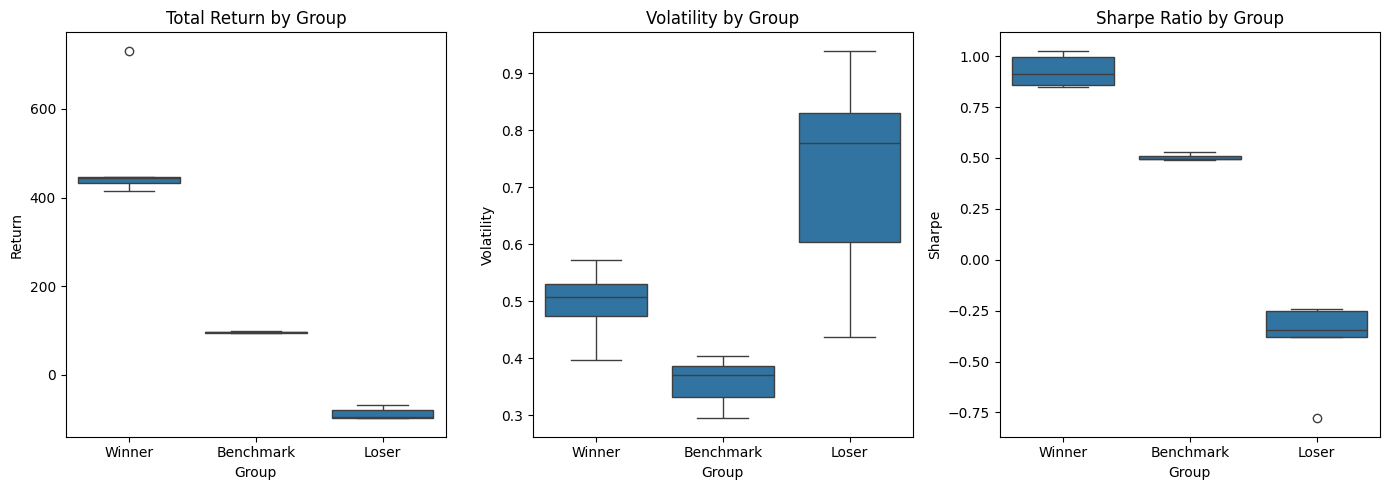

In [45]:
########################################
# 7. Group Comparisons via Boxplots
########################################
# Boxplots of Return, Volatility, Sharpe for each group
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Group", y="Return", data=group_df, order=["Winner", "Benchmark", "Loser"])
plt.title("Total Return by Group")

plt.subplot(1, 3, 2)
sns.boxplot(x="Group", y="Volatility", data=group_df, order=["Winner", "Benchmark", "Loser"])
plt.title("Volatility by Group")

plt.subplot(1, 3, 3)
sns.boxplot(x="Group", y="Sharpe", data=group_df, order=["Winner", "Benchmark", "Loser"])
plt.title("Sharpe Ratio by Group")

plt.tight_layout()
plt.savefig('group_comparisons_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()


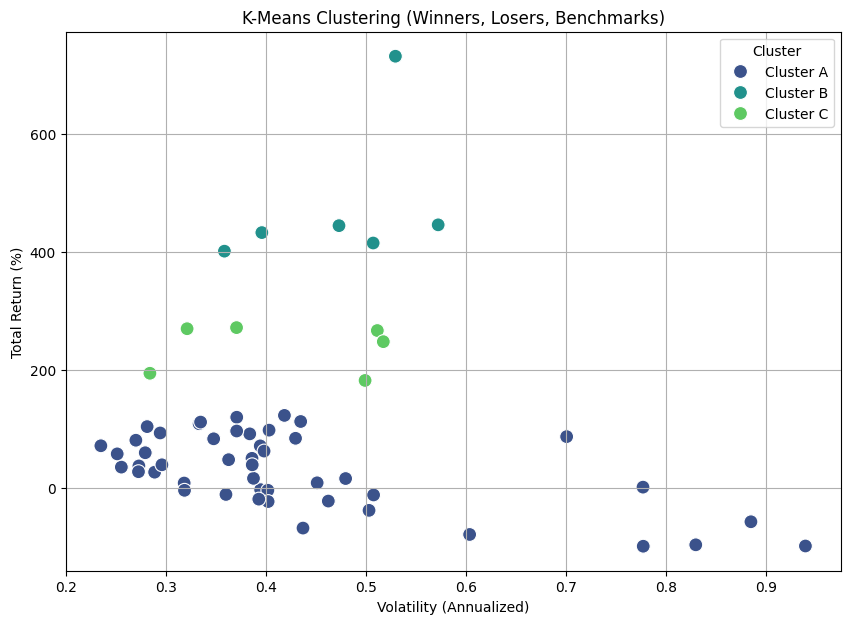


=== K-Means Cluster Centers ===
[[3.04663912e+01 4.27146877e-01 2.50585866e-01]
 [4.78491137e+02 4.72607508e-01 9.43754341e-01]
 [2.38723770e+02 4.17168955e-01 7.73684945e-01]]

=== Tickers and Their Clusters ===
           Return  Volatility    Sharpe    Cluster
ACIW    -3.047672    0.394594  0.131603  Cluster A
ACLS   445.837462    0.572081  0.846596  Cluster B
ADBE   119.732953    0.370713  0.557771  Cluster A
ADI     83.169872    0.347636  0.465260  Cluster A
ADP     59.552477    0.279230  0.403960  Cluster A
ADSK    71.163118    0.394203  0.420108  Cluster A
AGYS   266.699299    0.511256  0.726513  Cluster C
AMD    731.648870    0.529335  1.026467  Cluster B
ASGN    62.394301    0.398034  0.394205  Cluster A
AZPN    97.869189    0.403016  0.491000  Cluster A
BBSI    50.080592    0.385961  0.353643  Cluster A
BHE     16.163145    0.387443  0.222058  Cluster A
BLKB    -4.047594    0.401835  0.129856  Cluster A
CACI   103.844264    0.281136  0.577101  Cluster A
CAMP   -98.896278    

In [46]:


########################################
# 8. Segmentation Analysis (K-Means)
########################################
# Prepare features for clustering
features = group_df[["Return", "Volatility", "Sharpe"]].dropna().copy()

# Run K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
features["Cluster_ID"] = kmeans.fit_predict(features)

# Map numeric cluster IDs to labels
cluster_map = {0: "Cluster A", 1: "Cluster B", 2: "Cluster C"}
features["Cluster"] = features["Cluster_ID"].map(cluster_map)

# Scatter plot of Return vs Volatility colored by Cluster
plt.figure(figsize=(10, 7))
sns.scatterplot(x="Volatility", y="Return", hue="Cluster", data=features, s=100, palette="viridis")
plt.title("K-Means Clustering (Winners, Losers, Benchmarks)")
plt.xlabel("Volatility (Annualized)")
plt.ylabel("Total Return (%)")
plt.grid(True)
plt.savefig('kmeans_clustering.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== K-Means Cluster Centers ===")
print(kmeans.cluster_centers_)

print("\n=== Tickers and Their Clusters ===")
print(features[["Return", "Volatility", "Sharpe", "Cluster"]])

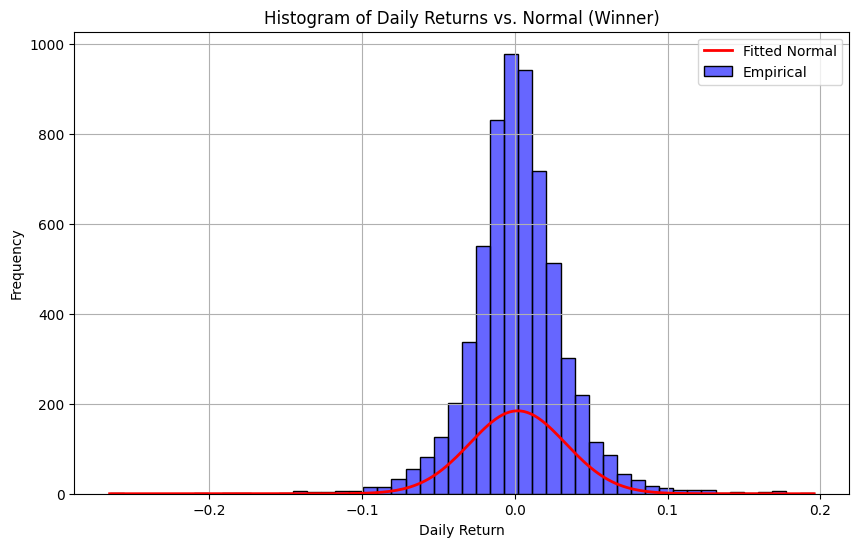

<Figure size 800x600 with 0 Axes>

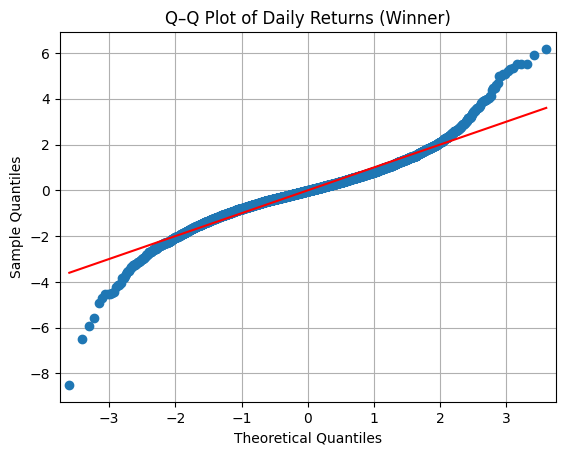

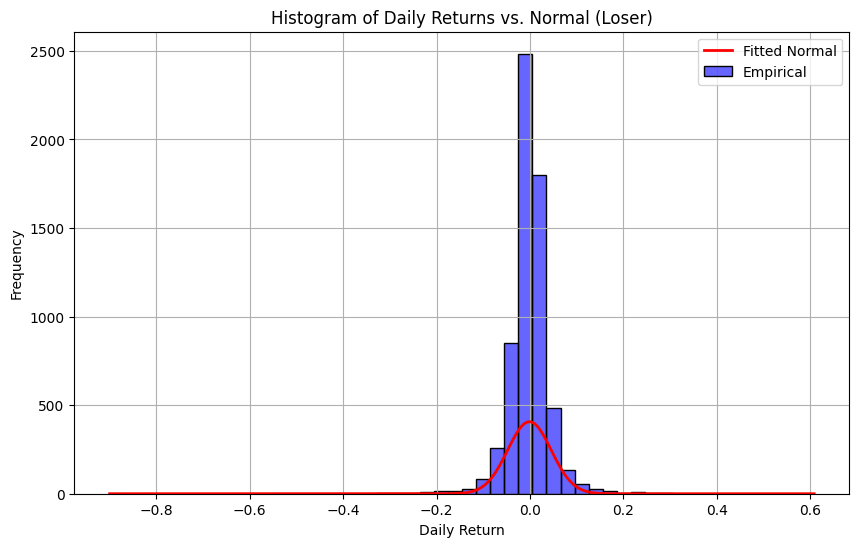

<Figure size 800x600 with 0 Axes>

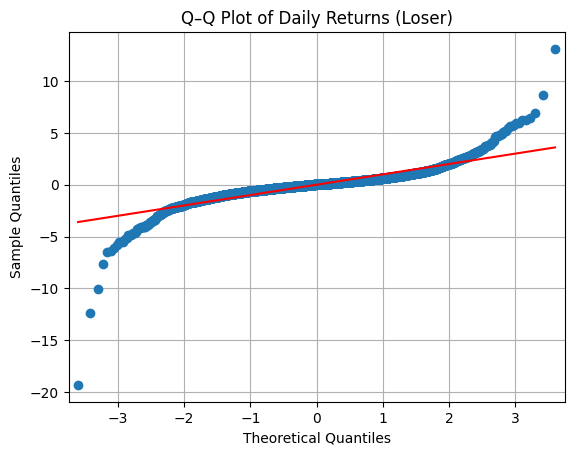

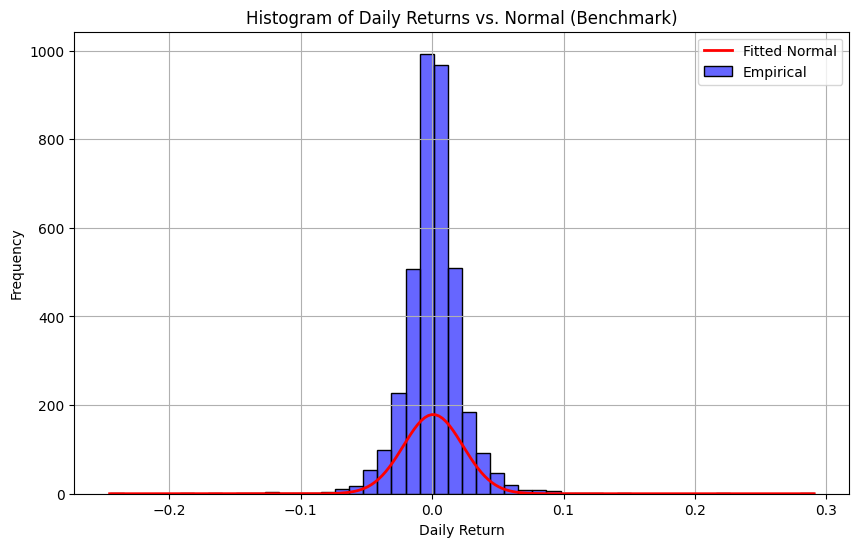

<Figure size 800x600 with 0 Axes>

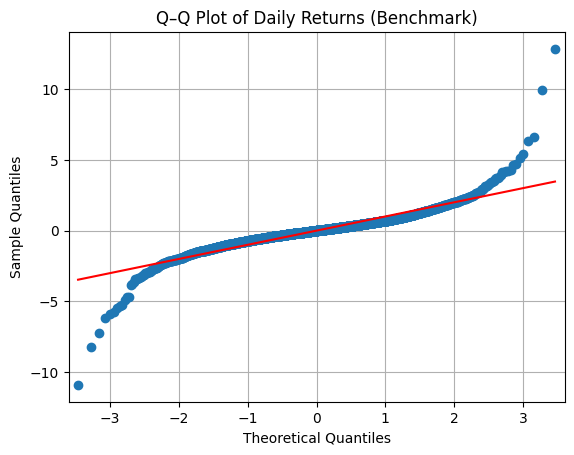


All analyses complete. Figures have been saved.


In [47]:



########################################
# Fat Tails Analysis (Histogram & Q-Q Plot)
########################################
def plot_fat_tails_for_group(group_name, group_df, daily_returns):
    """Plots histogram vs. normal and Q–Q plot of daily returns for the given group."""
    
    # Extract tickers in this group
    tickers = group_df[group_df["Group"] == group_name].index
    if len(tickers) == 0:
        print(f"No tickers in group: {group_name}")
        return
    
    # Filter daily_returns to these tickers only
    subset_df = daily_returns[tickers].dropna(how='all', axis=1)
    if subset_df.empty:
        print(f"No daily return data for group: {group_name}")
        return
    
    # Flatten to one long Series of daily returns
    stacked_returns = subset_df.stack().dropna()
    
    # 1) HISTOGRAM WITH FITTED NORMAL
    plt.figure(figsize=(10, 6))
    sns.histplot(stacked_returns, kde=False, color='blue', bins=50, alpha=0.6, label='Empirical')
    
    # Fit normal distribution
    mu, std = stats.norm.fit(stacked_returns)
    xmin, xmax = stacked_returns.min(), stacked_returns.max()
    x = np.linspace(xmin, xmax, 200)
    p = stats.norm.pdf(x, mu, std)
    p_scaled = p * len(stacked_returns) * (xmax - xmin) / 200
    plt.plot(x, p_scaled, 'r', linewidth=2, label='Fitted Normal')
    
    plt.title(f'Histogram of Daily Returns vs. Normal ({group_name})')
    plt.xlabel('Daily Return')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'fat_tails_hist_{group_name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2) Q-Q PLOT
    plt.figure(figsize=(8, 6))
    sm.qqplot(stacked_returns, line='s', fit=True)
    plt.title(f'Q–Q Plot of Daily Returns ({group_name})')
    plt.grid(True)
    plt.savefig(f'fat_tails_qq_{group_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Run fat-tails analysis for each group
for grp in ["Winner", "Loser", "Benchmark"]:
    plot_fat_tails_for_group(grp, group_df, daily_returns)

print("\nAll analyses complete. Figures have been saved.")
